In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import model
import dataloader
import matplotlib.pyplot as plt
from math import log10
from IPython.display import clear_output, display
import datetime
from tensorboardX import SummaryWriter
import scipy.misc
import shutil
from imageio import imwrite
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale

In [4]:
import time
from collections import deque
import os
import habitat
import math
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import skimage
import skfmm
import gym
import logging
from torchvision import transforms
from PIL import Image
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.datasets.pointnav.pointnav_dataset import PointNavDatasetV1
import sys
if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt
import random
from typing import Type, Union
from habitat import Config, Env, RLEnv, make_dataset
from habitat_baselines.common.environments import get_env_class
from matplotlib.patches import Circle
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [5]:
from arguments import get_args,multiple_config,init_config
from utils import draw_top_down_map
from env import Env as MyEnv
import pose as pu

In [6]:
argumnts = ''
args = get_args(argumnts)
args.num_processes = 8

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
args_list, env_configs = multiple_config(args)
config = env_configs[0]
config.defrost()
config.SIMULATOR.TURN_ANGLE = 2
config.SIMULATOR.TILT_ANGLE = 2
config.SIMULATOR.FORWARD_STEP_SIZE = 0.05#0.05
config.freeze()

Auto GPU config:
Number of processes: 9
Number of processes on GPU 0: 9
Number of processes per GPU: 0


# SloMo load

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flowComp = model.UNet(6, 4)
flowComp.to(device)
ArbTimeFlowIntrp = model.UNet(20, 5)
ArbTimeFlowIntrp.to(device)
flowBackWarp = model.backWarp(640, 352, device)
flowBackWarp = flowBackWarp.to(device)

In [8]:
pretrained_state = torch.load('SuperSloMo1.ckpt', map_location="cpu")
flowComp.load_state_dict(pretrained_state['state_dictFC'])
ArbTimeFlowIntrp.load_state_dict(pretrained_state['state_dictAT'])

<All keys matched successfully>

In [9]:
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,
                                 std=std)
negmean = [x * -1 for x in mean]
revNormalize = transforms.Normalize(mean=negmean, std=std)
transform = transforms.Compose([transforms.ToTensor(), 
                                normalize])
TP = transforms.Compose([revNormalize, transforms.ToPILImage()])
#                        transforms.Resize((352, 640),interpolation = Image.NEAREST)])

# Env

In [10]:
env = MyEnv(config=config)

2020-06-02 21:32:27,555 Initializing dataset PointNav-v1
Initializing dataset PointNav-v1
2020-06-02 21:32:39,600 initializing sim Sim-v0
initializing sim Sim-v0
2020-06-02 21:32:44,629 Initializing task Nav-v0
Initializing task Nav-v0


In [35]:
!rm -r ./one_video
os.mkdir('./one_video')
obs,info, done = env.reset()

## Test slomo

In [12]:
i = 0
while not done:
    obs,info,done = env.step(2,ideal_action=True)
    imwrite('{}/{:>3}.jpg'.format('./one_video',i), obs['rgb'])
    i+=1

KeyboardInterrupt: 

In [28]:
!ffmpeg -framerate 20 -pattern_type glob -i '/root/SLOMO_final/one_video/*.jpg' -c:v libx264 -r 20 -pix_fmt yuv420p /root/SLOMO_final/out.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [12]:
extractionPath = './one_video'
videoFrames = dataloader.Video(root=extractionPath, transform=transform)
videoFramesloader = torch.utils.data.DataLoader(videoFrames, batch_size=1, shuffle=False)

In [13]:
videoFrames.origDim

(640, 360)

In [30]:
frameCounter = 1
!rm -r ./one_video_10x
outputPath = './one_video_10x'
framerate = 10
os.mkdir(outputPath)
with torch.no_grad():
    for _, (frame0, frame1) in enumerate(tqdm(videoFramesloader), 0):
        
        I0 = frame0.to(device)
        I1 = frame1.to(device)

        flowOut = flowComp(torch.cat((I0, I1), dim=1))
        F_0_1 = flowOut[:,:2,:,:]
        F_1_0 = flowOut[:,2:,:,:]

        # Save reference frames in output folder
        for batchIndex in range(1):
            (TP(frame0[batchIndex].detach())).resize(videoFrames.origDim, Image.BILINEAR).save(os.path.join(outputPath, '{:>4}'.format(str(frameCounter + framerate * batchIndex)) + '{}'.format(".png")))
        frameCounter += 1

        # Generate intermediate frames
        for intermediateIndex in range(1, framerate):
            t = float(intermediateIndex) / framerate
            temp = -t * (1 - t)
            fCoeff = [temp, t * t, (1 - t) * (1 - t), temp]

            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            g_I0_F_t_0 = flowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = flowBackWarp(I1, F_t_1)

            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))

            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0

            g_I0_F_t_0_f = flowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = flowBackWarp(I1, F_t_1_f)

            wCoeff = [1 - t, t]

            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)

            # Save intermediate frame
            for batchIndex in range(1):
                (TP(Ft_p[batchIndex].cpu().detach())).resize(videoFrames.origDim, Image.BILINEAR).save(os.path.join(outputPath, '{:>4}'.format(str(frameCounter + framerate * batchIndex)) + '{}'.format(".png")))
            frameCounter += 1

        # Set counter accounting for batching of frames
        frameCounter += framerate * (1 - 1)

  0%|          | 0/163 [00:00<?, ?it/s]/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
100%|██████████| 163/163 [05:49<00:00,  2.15s/it]


In [31]:
!ffmpeg -framerate 20 -pattern_type glob -i '/root/SLOMO_final/one_video_10x/*.png' -c:v libx264 -r 20 -pix_fmt yuv420p /root/SLOMO_final/out10x.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

# OrbSlam

In [18]:
from habitat_baselines.config.default import get_config as cfg_baseline
from habitat_baselines.slambased.mappers import DirectDepthMapper
from habitat_baselines.slambased.reprojection import (
    angle_to_pi_2_minus_pi_2 as norm_ang)
import orbslam2
from habitat_baselines.slambased.reprojection import (
    homogenize_p,
    project_tps_into_worldmap)

In [19]:
agent_config = cfg_baseline()
agent_config.defrost()
config.defrost()
config.ORBSLAM2 = agent_config.ORBSLAM2
config.SLAM_VOCAB_PATH = '/root/3rdparty/ORB_SLAM2/Vocabulary/ORBvoc.txt'
config.SLAM_SETTINGS_PATH = '/habitat-api/habitat_baselines/slambased/data/mp3d3_small1k.yaml'
config.ORBSLAM2.CAMERA_HEIGHT = config.SIMULATOR.DEPTH_SENSOR.POSITION[1]
config.ORBSLAM2.H_OBSTACLE_MIN = (0.3 * config.ORBSLAM2.CAMERA_HEIGHT)
config.ORBSLAM2.H_OBSTACLE_MAX = (1.0 * config.ORBSLAM2.CAMERA_HEIGHT)
config.ORBSLAM2.MIN_PTS_IN_OBSTACLE = (config.SIMULATOR.DEPTH_SENSOR.WIDTH / 2.0)
agent_config.freeze()
config.freeze()

In [20]:
mapper = DirectDepthMapper(
            camera_height=config.ORBSLAM2.CAMERA_HEIGHT,
            near_th=config.ORBSLAM2.D_OBSTACLE_MIN,
            far_th=config.ORBSLAM2.D_OBSTACLE_MAX,
            h_min=config.ORBSLAM2.H_OBSTACLE_MIN,
            h_max=config.ORBSLAM2.H_OBSTACLE_MAX,
            map_size=config.ORBSLAM2.MAP_SIZE,
            map_cell_size=config.ORBSLAM2.MAP_CELL_SIZE,
            device=device,
        )
slam = orbslam2.System(config.SLAM_VOCAB_PATH, config.SLAM_SETTINGS_PATH, orbslam2.Sensor.RGBD)
slam.set_use_viewer(False)
slam.initialize()

True

In [21]:
!rm -r ./one_video
os.mkdir('./one_video')
!rm -r ./one_video_10x
outputPath = './one_video_10x'
os.mkdir(outputPath)
!rm -r ./one_video_10x_d
os.mkdir('./one_video_10x_d')
obs,info, done = env.reset()
frame0 = obs['rgb']
frame0_d = obs['depth']
slam.reset()
map2DObstacles = torch.zeros(1, 1, int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE), int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE)).float().to(device)
cur_time = 0
framerate = 10
tru_cords = []
orb_cords = []
orb_cords2 = []

In [22]:
transform1 = transforms.Compose([transforms.ToTensor(), 
                                normalize])
TP = transforms.Compose([revNormalize, transforms.ToPILImage()])
#                        transforms.Resize((352, 640),interpolation = Image.NEAREST)])

In [23]:
done=False
cur_time += 0.1
cur_time2 = 0.001
n = 0
nn=0
frms = []
frms_d = []
while not done:
    
    obs,info,done = env.step(2,ideal_action=True)
    tru_cords.append([env.trux,env.truy])
    imwrite('{}/{:>3}.jpg'.format('./one_video',n), obs['rgb'])
    frame1 = obs['rgb']
    frame1_d = obs['depth']
    if 1==1:
        mmax = np.copy(frame1_d[4:-4]).max()
        if mmax==0:
            mmax=0.001
        shape = frame0_d[4:-4].shape
        im = np.uint8(minmax_scale(frame0_d[4:-4].ravel(), feature_range=(0,255)).reshape(shape)[:,:,0])
        I0 = np.zeros_like(frame0[4:-4])
        I0[:,:,1] = transforms.ToPILImage()(im)
        shape = frame1_d[4:-4].shape
        im = np.uint8(minmax_scale(frame1_d[4:-4].ravel(), feature_range=(0,255)).reshape(shape)[:,:,0])
        I1 = np.zeros_like(frame1[4:-4])
        I1[:,:,1] = transforms.ToPILImage()(im)

        I0_d = transform1(I0).unsqueeze(0).to(device)
        I1_d = transform1(I1).unsqueeze(0).to(device)
        flowOut = flowComp(torch.cat((I0_d, I1_d), dim=1))
        F_0_1 = flowOut[:,:2,:,:]
        F_1_0 = flowOut[:,2:,:,:]
        for intermediateIndex in range(1, framerate):
            t = float(intermediateIndex) / framerate
            temp = -t * (1 - t)
            fCoeff = [temp, t * t, (1 - t) * (1 - t), temp]
            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0
            g_I0_F_t_0 = flowBackWarp(I0_d, F_t_0)
            g_I1_F_t_1 = flowBackWarp(I1_d, F_t_1)
            intrpOut = ArbTimeFlowIntrp(torch.cat((I0_d, I1_d, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0
            g_I0_F_t_0_f = flowBackWarp(I0_d, F_t_0_f)
            g_I1_F_t_1_f = flowBackWarp(I1_d, F_t_1_f)
            wCoeff = [1 - t, t]
            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
            frms_d.append(np.expand_dims(np.array(revNormalize(Ft_p[0].cpu().detach())).ravel().reshape([3, 352, 640])[1], axis=2))
            (TP(Ft_p[0].cpu().detach())).resize((640, 360), Image.BILINEAR).save(os.path.join('./one_video_10x_d', '{:>4}'.format(nn) + '{}'.format(".png")))
            nn+=1
        
        I0 = transform1(frame0[4:-4]).unsqueeze(0).to(device)
        I1 = transform1(frame1[4:-4]).unsqueeze(0).to(device)
        flowOut = flowComp(torch.cat((I0, I1), dim=1))
        F_0_1 = flowOut[:,:2,:,:]
        F_1_0 = flowOut[:,2:,:,:]
        
        for intermediateIndex in range(1, framerate):
            t = float(intermediateIndex) / framerate
            temp = -t * (1 - t)
            fCoeff = [temp, t * t, (1 - t) * (1 - t), temp]

            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            g_I0_F_t_0 = flowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = flowBackWarp(I1, F_t_1)

            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))

            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0

            g_I0_F_t_0_f = flowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = flowBackWarp(I1, F_t_1_f)

            wCoeff = [1 - t, t]

            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
            (TP(Ft_p[0].cpu().detach())).resize((640, 360), Image.BILINEAR).save(os.path.join(outputPath, '{:>4}'.format(n) + '{}'.format(".png")))
            frms.append(np.array(TP(Ft_p[0].cpu().detach())))
            n+=1
        
#    break
       
    if 1==1:
        slam.process_image_rgbd(obs['rgb'], obs['depth'], cur_time2)
        track = slam.get_tracking_state()
        pose6D = homogenize_p(torch.from_numpy(np.array(slam.get_trajectory_points())[-1])[1:].view(3, 4).to(device)).view(1, 4, 4)
        current_obstacles = mapper(torch.from_numpy(obs['depth']).to(device).squeeze(), pose6D).to(device)
        map2DObstacles = torch.max(map2DObstacles, current_obstacles.unsqueeze(0).unsqueeze(0))
        get_position_on_map = project_tps_into_worldmap(
                pose6D.view(1, 4, 4),
                config.ORBSLAM2.MAP_CELL_SIZE,
                config.ORBSLAM2.MAP_SIZE,
                True)
        get_orientation_on_map = torch.tensor(
                [[pose6D.view(1, 4, 4)[0, 0, 0], pose6D.view(1, 4, 4)[0, 0, 2]],
                 [pose6D.view(1, 4, 4)[0, 2, 0], pose6D.view(1, 4, 4)[0, 2, 2]]])
        tps = pose6D.view(1, 4, 4)
        topdown_p = torch.tensor([[1.0, 0, 0, 0], [0, 0, 1.0, 0]]).to(device)
        world_coords = torch.bmm(
                topdown_p.view(1, 2, 4).expand(tps.size(0), 2, 4),
                tps[:, :, 3:].view(-1, 4, 1))[0]
        orb_cords2.append(world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1])
        cur_time2 += 0.1

    if done:
        print('DONE')
        break   
    frame0 = np.copy(frame1)
    frame0_d = np.copy(frame1_d)
   
slam.reset()
if 1==11:
    for i in range(len(frms)):
        rgb = frms[i]
        depth = frms_d[i]
        slam.process_image_rgbd(rgb, depth, cur_time)
        track = slam.get_tracking_state()
        pose6D = homogenize_p(torch.from_numpy(np.array(slam.get_trajectory_points())[-1])[1:].view(3, 4).to(device)).view(1, 4, 4)
        current_obstacles = mapper(torch.from_numpy(depth).to(device).squeeze(), pose6D).to(device)
        map2DObstacles = torch.max(map2DObstacles, current_obstacles.unsqueeze(0).unsqueeze(0))
        get_position_on_map = project_tps_into_worldmap(
                pose6D.view(1, 4, 4),
                config.ORBSLAM2.MAP_CELL_SIZE,
                config.ORBSLAM2.MAP_SIZE,
                True)
        get_orientation_on_map = torch.tensor(
                [[pose6D.view(1, 4, 4)[0, 0, 0], pose6D.view(1, 4, 4)[0, 0, 2]],
                 [pose6D.view(1, 4, 4)[0, 2, 0], pose6D.view(1, 4, 4)[0, 2, 2]]])
        tps = pose6D.view(1, 4, 4)
        topdown_p = torch.tensor([[1.0, 0, 0, 0], [0, 0, 1.0, 0]]).to(device)
        world_coords = torch.bmm(
                topdown_p.view(1, 2, 4).expand(tps.size(0), 2, 4),
                tps[:, :, 3:].view(-1, 4, 1))[0]
        orb_cords.append(world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1])
        cur_time += 0.1    
print(world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1],'\t',[env.trux,env.truy])

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


NameError: name 'world_coords' is not defined

In [24]:
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler

class Scaler(BaseEstimator,TransformerMixin):

    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(X.shape[0], -1))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

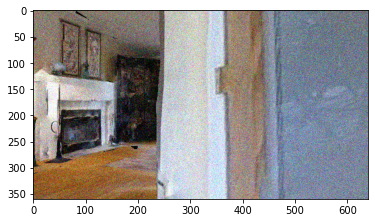

In [32]:
plt.imshow(frame1)

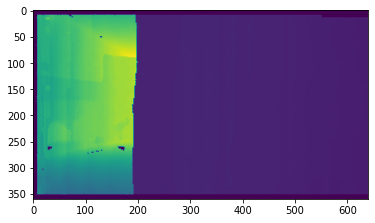

In [26]:
plt.imshow(frame0_d[:,:,0])

In [27]:
frms_d[0].shape

(352, 640, 1)

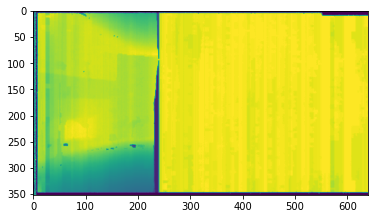

In [31]:
i = 8
plt.imshow(minmax_scale(np.vstack(frms_d)[:,:,0])[352*i:352*(i+1),:])

In [39]:
minmax_scale(np.vstack(frms_d)[:,:,0]).shape

(3168, 640)

In [28]:
!ffmpeg -framerate 20 -pattern_type glob -i '/root/SLOMO_final/one_video/*.jpg' -c:v libx264 -r 20 -pix_fmt yuv420p /root/SLOMO_final/out.mp4 -y
!ffmpeg -framerate 20 -pattern_type glob -i '/root/SLOMO_final/one_video_10x/*.png' -c:v libx264 -r 20 -pix_fmt yuv420p /root/SLOMO_final/out10x.mp4 -y   
!ffmpeg -framerate 20 -pattern_type glob -i '/root/SLOMO_final/one_video_10x_d/*.png' -c:v libx264 -r 20 -pix_fmt yuv420p /root/SLOMO_final/out10x_d.mp4 -y    

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

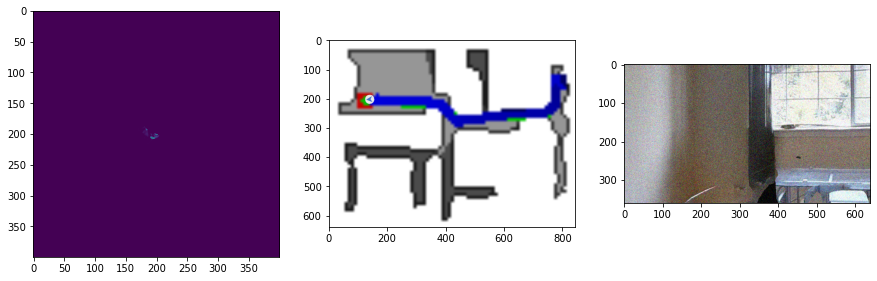

In [18]:
top_down_map = draw_top_down_map(info, obs["heading"][0], obs['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax.imshow(map2DObstacles[0][0].cpu())
ax2.imshow(top_down_map)
ax3.imshow(obs['rgb'])

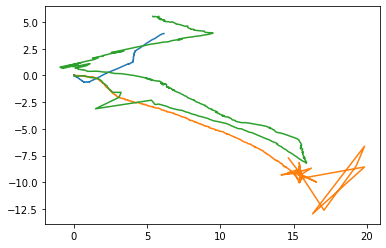

In [19]:
x = np.array(tru_cords)[:,0].T
y = np.array(tru_cords)[:,1].T
x1 = np.array(orb_cords)[:,0].T
y1 = np.array(orb_cords)[:,1].T
x2 = np.array(orb_cords2)[:,0].T
y2 = np.array(orb_cords2)[:,1].T
plt.plot(y, x)
plt.plot(y1, x1)
plt.plot(y2, x2)

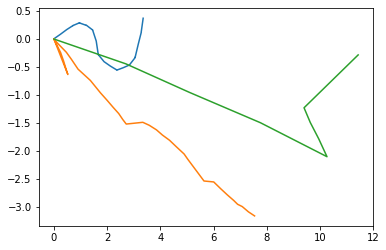

In [20]:
x = np.array(tru_cords)[:,0].T
y = np.array(tru_cords)[:,1].T
x1 = np.array(orb_cords)[:,0].T
y1 = np.array(orb_cords)[:,1].T
x2 = np.array(orb_cords2)[:,0].T
y2 = np.array(orb_cords2)[:,1].T
plt.plot(y, x)
plt.plot(y1, x1)
plt.plot(y2, x2)

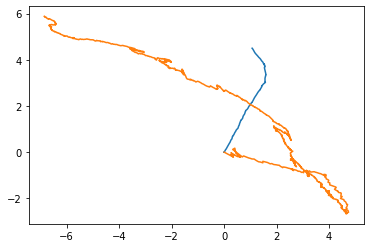

In [55]:
x = np.array(tru_cords)[:,0].T
y = np.array(tru_cords)[:,1].T
x1 = np.array(orb_cords)[:,0].T
y1 = np.array(orb_cords)[:,1].T
plt.plot(y, x)
plt.plot(y1, x1)

In [47]:
obs,info, done = env.reset()
slam.reset()
map2DObstacles = torch.zeros(1, 1, int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE), int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE)).float().to(device)
cur_time = 0
tru_cords = []
orb_cords = []

In [48]:
while not done:
    cur_time += 0.1
    obs,info,done = env.step(2,ideal_action=True)
    if done:
        print('DONE')
        break
    slam.process_image_rgbd(obs['rgb'], obs['depth'], cur_time)
    track = slam.get_tracking_state()
    pose6D = homogenize_p(torch.from_numpy(np.array(slam.get_trajectory_points())[-1])[1:].view(3, 4).to(device)).view(1, 4, 4)
    current_obstacles = mapper(torch.from_numpy(obs['depth']).to(device).squeeze(), pose6D).to(device)
    map2DObstacles = torch.max(map2DObstacles, current_obstacles.unsqueeze(0).unsqueeze(0))
    get_position_on_map = project_tps_into_worldmap(
            pose6D.view(1, 4, 4),
            config.ORBSLAM2.MAP_CELL_SIZE,
            config.ORBSLAM2.MAP_SIZE,
            True)
    get_orientation_on_map = torch.tensor(
            [[pose6D.view(1, 4, 4)[0, 0, 0], pose6D.view(1, 4, 4)[0, 0, 2]],
             [pose6D.view(1, 4, 4)[0, 2, 0], pose6D.view(1, 4, 4)[0, 2, 2]]])
    tps = pose6D.view(1, 4, 4)
    topdown_p = torch.tensor([[1.0, 0, 0, 0], [0, 0, 1.0, 0]]).to(device)
    world_coords = torch.bmm(
            topdown_p.view(1, 2, 4).expand(tps.size(0), 2, 4),
            tps[:, :, 3:].view(-1, 4, 1))[0]
    tru_cords.append([env.trux,env.truy])
    orb_cords.append(world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1])
print(world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1],'\t',[env.trux,env.truy])

DONE
[ 0.13951533 -2.47886276] 	 [-3.5322626967052244, -0.7733284309807935]


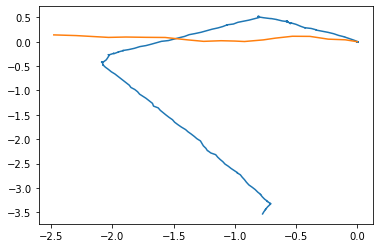

In [49]:
x = np.array(tru_cords)[:,0].T
y = np.array(tru_cords)[:,1].T
x1 = np.array(orb_cords)[:,0].T
y1 = np.array(orb_cords)[:,1].T
plt.plot(y, x)
plt.plot(y1, x1)